In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#importing data
df = pd.read_csv('Telco-Customer-Churn.csv')

In [2]:
#A first look at the data
print(df.shape)
print(df.info())
print(df.describe())
print(df.isnull().sum())

(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

In [3]:
#Handling the incorrect data
#convert totalcharges to numeric, forching errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

#checking how many null values wee created
print(df['TotalCharges'].isnull().sum())

#Fill the NaN with 0 (New customer who hasnt been charged)
df['TotalCharges'].fillna(0, inplace = True)

11


C:\Users\ELITEX21012G2\AppData\Local\Temp\ipykernel_17504\2618332095.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace = True)


Churn
No     5174
Yes    1869
Name: count, dtype: int64


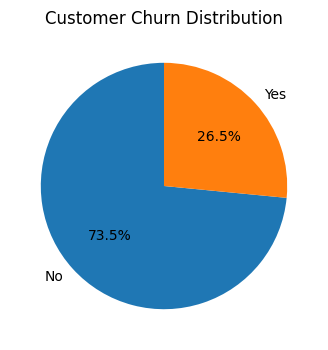

In [4]:
#Exploring the Target Variable
#check for class imbalance
churn_counts = df['Churn'].value_counts()
print(churn_counts)

#visualization
plt.figure(figsize=(6,4))
plt.pie(churn_counts, labels=churn_counts.index, autopct = '%1.1f%%', startangle = 90)
plt.title('Customer Churn Distribution')
plt.show()

# Insight
There is significant class imbalance (5000 retained vs 2000 churned). This is normal in churn problems. We account for this later using stratification in train-test split or class weights in the model.

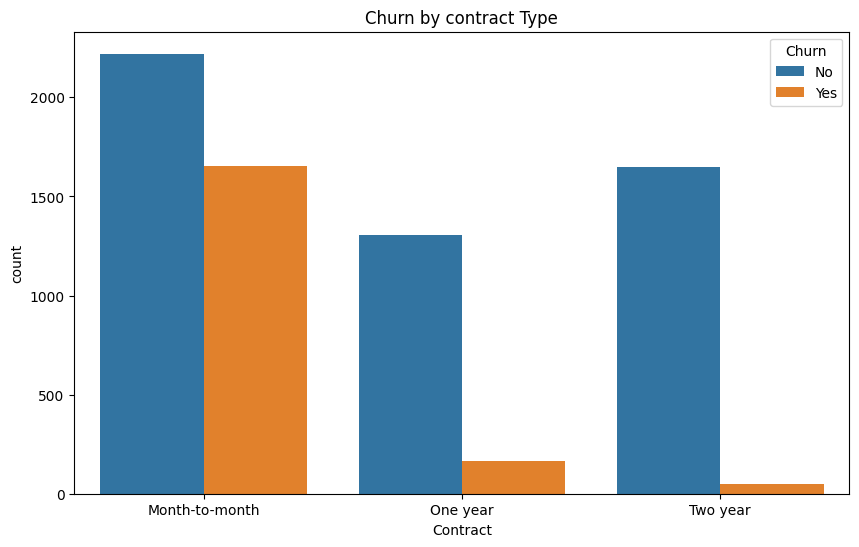

In [5]:
#Explorte Relationship Between Features and Churn:
#Creating visualization to see what drives churn.

#Categorical Features 
plt.figure(figsize= (10,6))
sns.countplot(data = df, x ='Contract', hue ='Churn')
plt.title('Churn by contract Type')
plt.show()

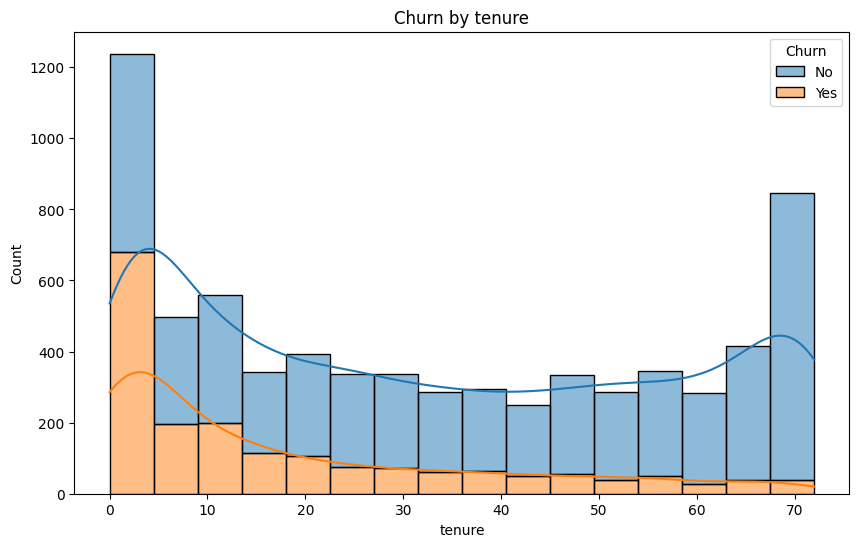

In [6]:
plt.figure(figsize = (10,6))
sns.histplot(data = df, x = 'tenure', hue ='Churn', multiple='stack', kde = True)
plt.title('Churn by tenure')
plt.show()

# Insight
New customer (with low tenure), are more likely to churn as compared to Loyal Customers (with high tenure) who present with more stability.

In [7]:
#3 Data Processing for Machine Learning
#Encode Categorical Variables

df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})
df['Partner'] =df['Partner'].map({'Yes':1,'No':0})
df['Dependents'] = df['Dependents'].map({'Yes':1, 'No':0})
df['PhoneService'] = df['PhoneService'].map({'Yes':1, 'No':0})
df['PaperlessBilling'] =df['PaperlessBilling'].map({'Yes':1, 'No':0})
df['Churn'] =df['Churn'].map({'Yes':1, 'No':0})

In [8]:
#Multi-Category Variable using One-Hot Ecoding
df = pd.get_dummies(
    df,
    columns=[
        'MultipleLines',
        'OnlineSecurity',
        'InternetService',
        'OnlineBackup',
        'TechSupport',
        'StreamingTV',
        'StreamingMovies',
        'Contract'
    ],
    drop_first=True   # drops one dummy per feature to avoid multicollinearity
)

In [9]:
#Splitting the data into training data
from sklearn.model_selection import train_test_split

# Seperate features (X) and target (y)
X= df.drop('Churn', axis =1)
y = df['Churn']

#Split data into training (80%) and testing (20%) sets. Use stratification to handle imbalance
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state = 42, stratify = y)

In [10]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler

# Drop non-numeric columns before scaling
non_numeric_cols = ['customerID', 'DeviceProtection', 'PaymentMethod']
X_train_numeric = X_train.drop(columns=non_numeric_cols)
X_test_numeric = X_test.drop(columns=non_numeric_cols)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

In [11]:
# Building and Train Machine Learning Models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

dt_model = DecisionTreeClassifier(random_state=42, max_depth=5) # Limit depth to prevent overfitting

#Fitting the model
dt_model.fit(X_train_numeric, y_train)

#Making predictions
y_pred_dt = dt_model.predict(X_test_numeric)

print('Decision Tree Performance:')
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))

Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1035
           1       0.69      0.45      0.54       374

    accuracy                           0.80      1409
   macro avg       0.76      0.69      0.71      1409
weighted avg       0.79      0.80      0.78      1409

[[960  75]
 [207 167]]


In [12]:
# Random Forest Classifier:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf_model.fit(X_train_numeric, y_train)
y_pred_rt = rf_model.predict(X_test_numeric)

print('Random Forest Performance:')
print(classification_report(y_test, y_pred_rt))
print(confusion_matrix(y_test, y_pred_rt))

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.61      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409

[[919 116]
 [193 181]]


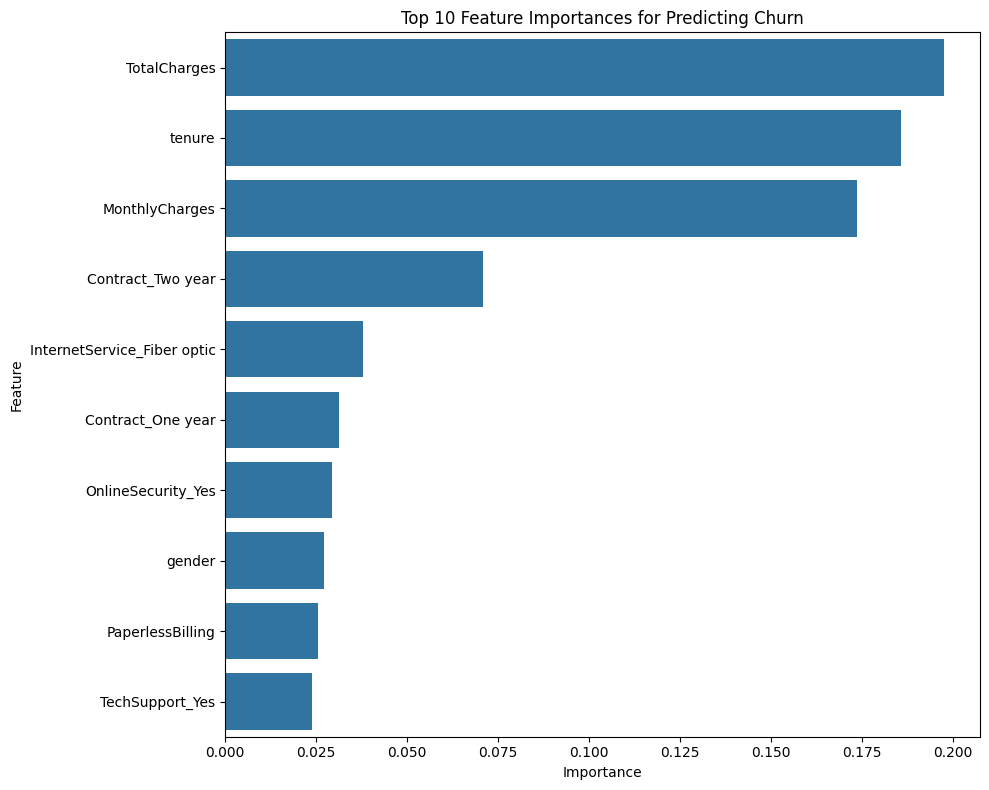

In [16]:
#Evaluate and Interprete the model
# Get Feature importances from the trained Random Forest
importances = rf_model.feature_importances_
feature_names = X_train_numeric.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False)

#Plotting the Top 10 most important features
plt.figure(figsize=(10,8))
sns.barplot(data=feat_imp_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Feature Importances for Predicting Churn')
plt.tight_layout()
plt.show()

Tenure, totalCharges, Contract_type (month-to-month) and paymentMethod_Electronic check are the top drivers of churn.

## Take Away
The financial factors dominate(charges + tenure). This is price and value perception problem more than the service quality issue. The retention campaigns need to focus heavily on demostrating value and potentially offering pricing adjustments for high-risk customers.